<a href="https://colab.research.google.com/github/simonme42/ANN_experiments/blob/master/ANN_from_scratch_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN from scratch

*   In this notebook, we implement an artificial neural network from scratch.
*   All we need are a few standard python libraries
*   At the end we´ll test our ANN implementation on image classification and regression tasks






In [0]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
import math

%matplotlib inline

# The functions that we need to implement a NN

In [0]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    #np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation="relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], activation="sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y, loss="crossentropy"):
    """
    Implement the cost function
    
    Arguments:
    AL -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function without dividing by number of training examples
    
    Note: 
    This is used with mini-batches, 
    so we'll first accumulate costs over an entire epoch 
    and then divide by the m training examples
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    if loss == "crossentropy":
      logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
      cost_total =  np.sum(logprobs)
    
    elif loss == "mse":
      cost_total = (np.sum((AL-Y)**2,axis=1, keepdims=True))
    
    cost_total = np.squeeze(cost_total)      # To make sure the cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost_total.shape == ())
    
    return cost_total

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches, loss="crossentropy"):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation

    if loss == "crossentropy":
      dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    elif loss == "mse":
      dAL = 2*(AL-Y)
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    #np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, mini_batch_size*k : mini_batch_size*(k+1)]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*k : mini_batch_size*(k+1)]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size*(k+1):]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*(k+1):]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
    
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1-beta1) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1-beta1) * grads['db' + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1-(beta1**t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1-(beta1**t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * grads['dW' + str(l+1)]**2
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * grads['db' + str(l+1)]**2

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1-(beta2**t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1-(beta2**t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * (v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * (v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon))

    return parameters, v, s

def predict(X, y, parameters, loss="crossentropy"):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network

    if loss == "crossentropy":
     
      p = np.zeros((1,m))
        
      # Forward propagation
      probas, caches = L_model_forward(X, parameters)
        
      # convert probas to 0/1 predictions
      for i in range(0, probas.shape[1]):
          if probas[0,i] > 0.5:
            p[0,i] = 1
          else:
            p[0,i] = 0
      
      print("Accuracy: "  + str(np.sum((p == y)/m)))

    elif loss == "mse":

      p, caches = L_model_forward(X, parameters)

      print("Accuracy: "  + str((1/m)*np.sum(p-y)**2))
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

def train_model(X, Y, layers_dims, learning_rate = 0.0075, num_epochs = 3000, print_cost=True, loss="crossentropy", optimizer="GD", mini_batch_size=64):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    m = X.shape[1]                   # number of training examples

    parameters = initialize_parameters_deep(layers_dims)

    # Initialize the optimizer
    if optimizer == "GD":
        pass # no initialization required for gradient descent
    elif optimizer == "Adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop 
    for i in range(num_epochs):
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            AL, caches = L_model_forward(minibatch_X, parameters)
            
            # Compute cost.
            cost_total += compute_cost(AL, minibatch_Y, loss=loss)
        
            # Backward propagation.
            grads = L_model_backward(AL, minibatch_Y, caches, loss=loss)
    
            # Update parameters.
            if optimizer == "GD":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "Adam":
                t = t + 1 # Adam counter
                parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)
                    
        cost_avg = cost_total / m
        
        # Print the cost every 100 epoch
        if print_cost and i % 100 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            costs.append(cost_avg)          
            
    # plot the cost
    print(cost_avg)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters


# Now we train and test our NN on binary image classification using cat vs noncat



In [47]:
!git clone https://github.com/simonme42/ANN_experiments.git

fatal: destination path 'ANN_experiments' already exists and is not an empty directory.


In [0]:
def load_data():
  train_dataset = h5py.File("ANN_experiments/datasets/train_catvnoncat.h5", "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File("ANN_experiments/datasets/test_catvnoncat.h5", "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [49]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Cost after epoch 0: 0.950002
Cost after epoch 100: 0.314264
Cost after epoch 200: 0.090814
Cost after epoch 300: 0.045565
Cost after epoch 400: 0.025845
Cost after epoch 500: 0.020783
Cost after epoch 600: 0.017948
Cost after epoch 700: 0.015492
Cost after epoch 800: 0.013643
Cost after epoch 900: 0.011532
Cost after epoch 1000: 0.009817
Cost after epoch 1100: 0.008744
Cost after epoch 1200: 0.008932
Cost after epoch 1300: 0.006070
Cost after epoch 1400: 0.005167
Cost after epoch 1500: 0.004373
Cost after epoch 1600: 0.003720
Cost after epoch 1700: 0.003168
Cost after epoch 1800: 0.002680
Cost after epoch 1900: 0.002284
0.001960239303298476


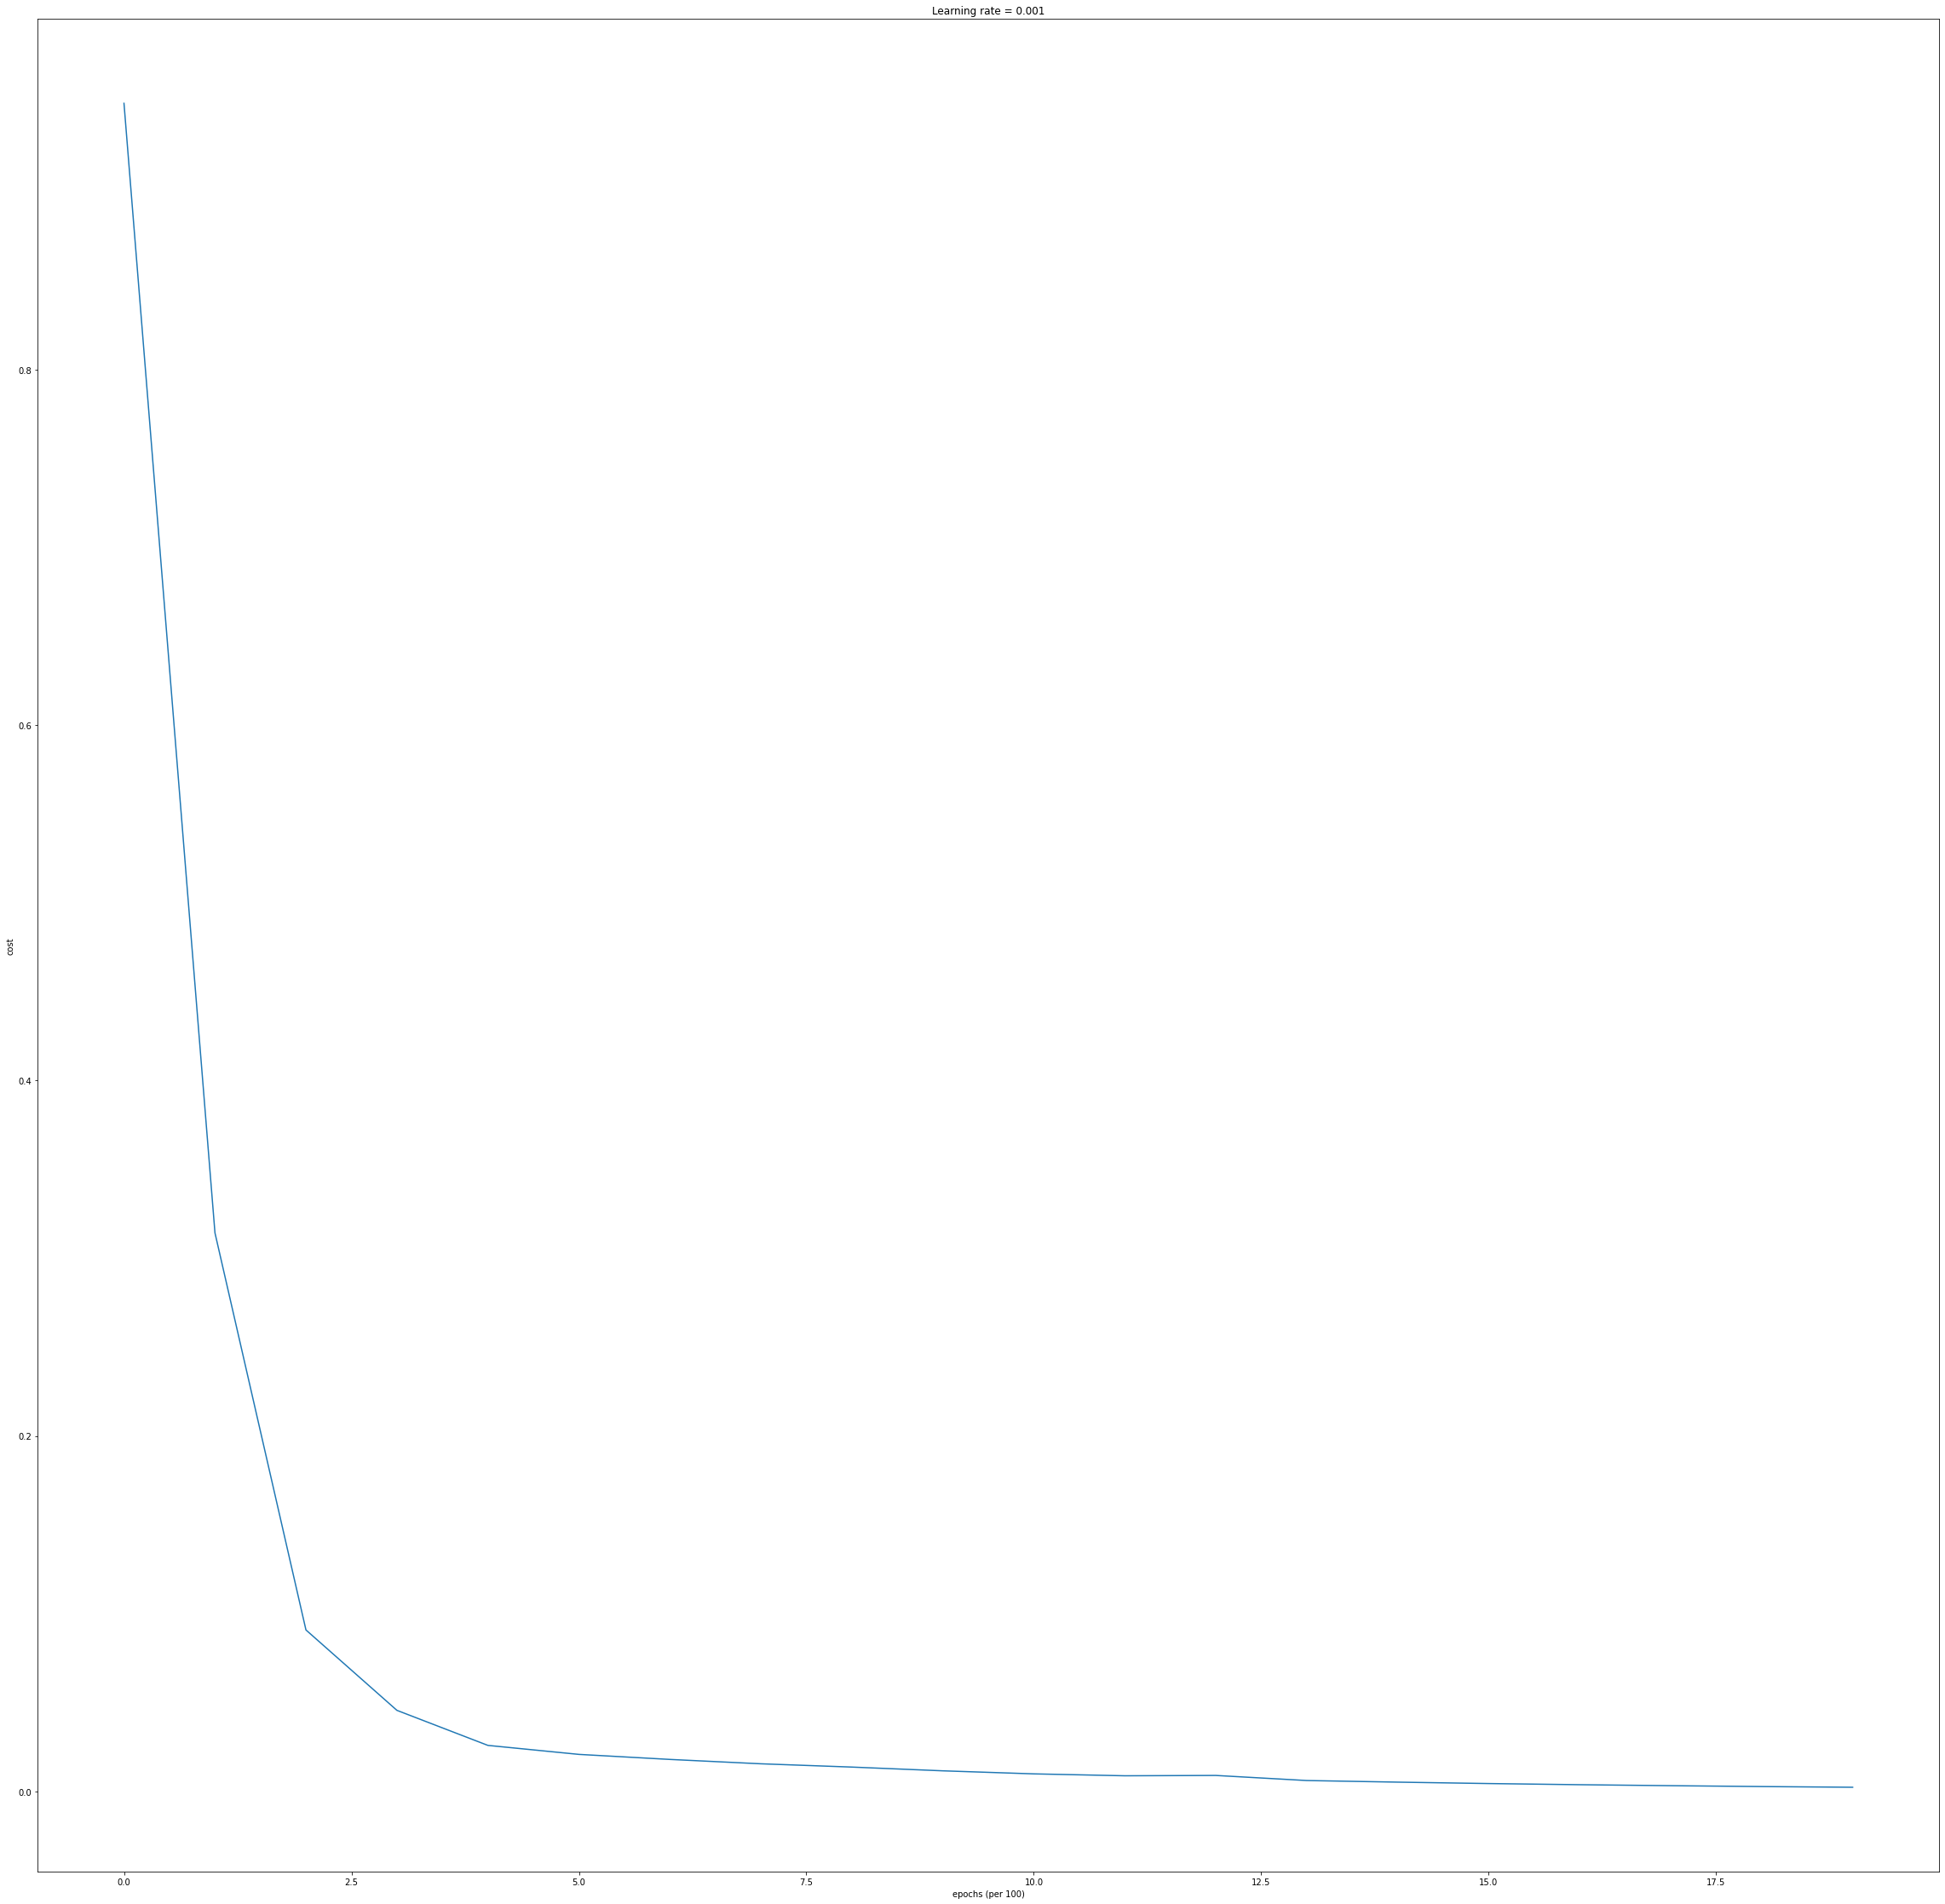

In [85]:
layers_dims = [train_x.shape[0], 20, 7, 5, 1]

parameters = train_model(train_x, train_y, layers_dims, learning_rate = 0.001, num_epochs = 2000, print_cost=True, loss="crossentropy", optimizer = "Adam")

In [84]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.6600000000000001


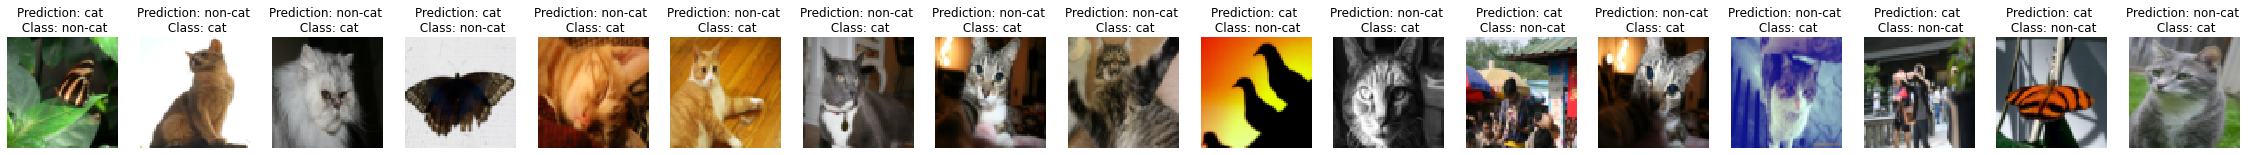

In [69]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

## Now we use our NN implementation for a Regression task (adding 2 numbers)

In [0]:
def create_mse_data(low, high, m, train_test_split=0.2):

  mse_X = np.random.randint(low,high=high, size=(2,m))
  mse_X_scaled = mse_X/(high)

  mse_Y = (mse_X[0,:]+mse_X[1,:]).reshape(1,mse_X.shape[1])
  mse_Y_scaled = mse_Y/(high*2)

  mse_X_train = mse_X_scaled[:,0:int(m*train_test_split)]
  mse_X_test = mse_X_scaled[:,int(m*train_test_split):]
  mse_Y_train = mse_Y_scaled[:,0:int(m*train_test_split)]
  mse_Y_test = mse_Y_scaled[:,int(m*train_test_split):]

  return (mse_X_train,mse_X_test,mse_Y_train,mse_Y_test)


(mse_X_train,mse_X_test,mse_Y_train,mse_Y_test) = create_mse_data(0,50,10000)

layers_dims_mse = [mse_X_train.shape[0],5,4,1]

Cost after epoch 0: 0.035006
Cost after epoch 100: 0.004432
Cost after epoch 200: 0.000466
Cost after epoch 300: 0.000288
Cost after epoch 400: 0.000263
Cost after epoch 500: 0.000259
Cost after epoch 600: 0.000256
Cost after epoch 700: 0.000255
Cost after epoch 800: 0.000255
Cost after epoch 900: 0.000255
Cost after epoch 1000: 0.000254
Cost after epoch 1100: 0.000254
Cost after epoch 1200: 0.000254
Cost after epoch 1300: 0.000254
Cost after epoch 1400: 0.000254
Cost after epoch 1500: 0.000253
Cost after epoch 1600: 0.000253
Cost after epoch 1700: 0.000254
Cost after epoch 1800: 0.000254
Cost after epoch 1900: 0.000254
0.0002532467671021517


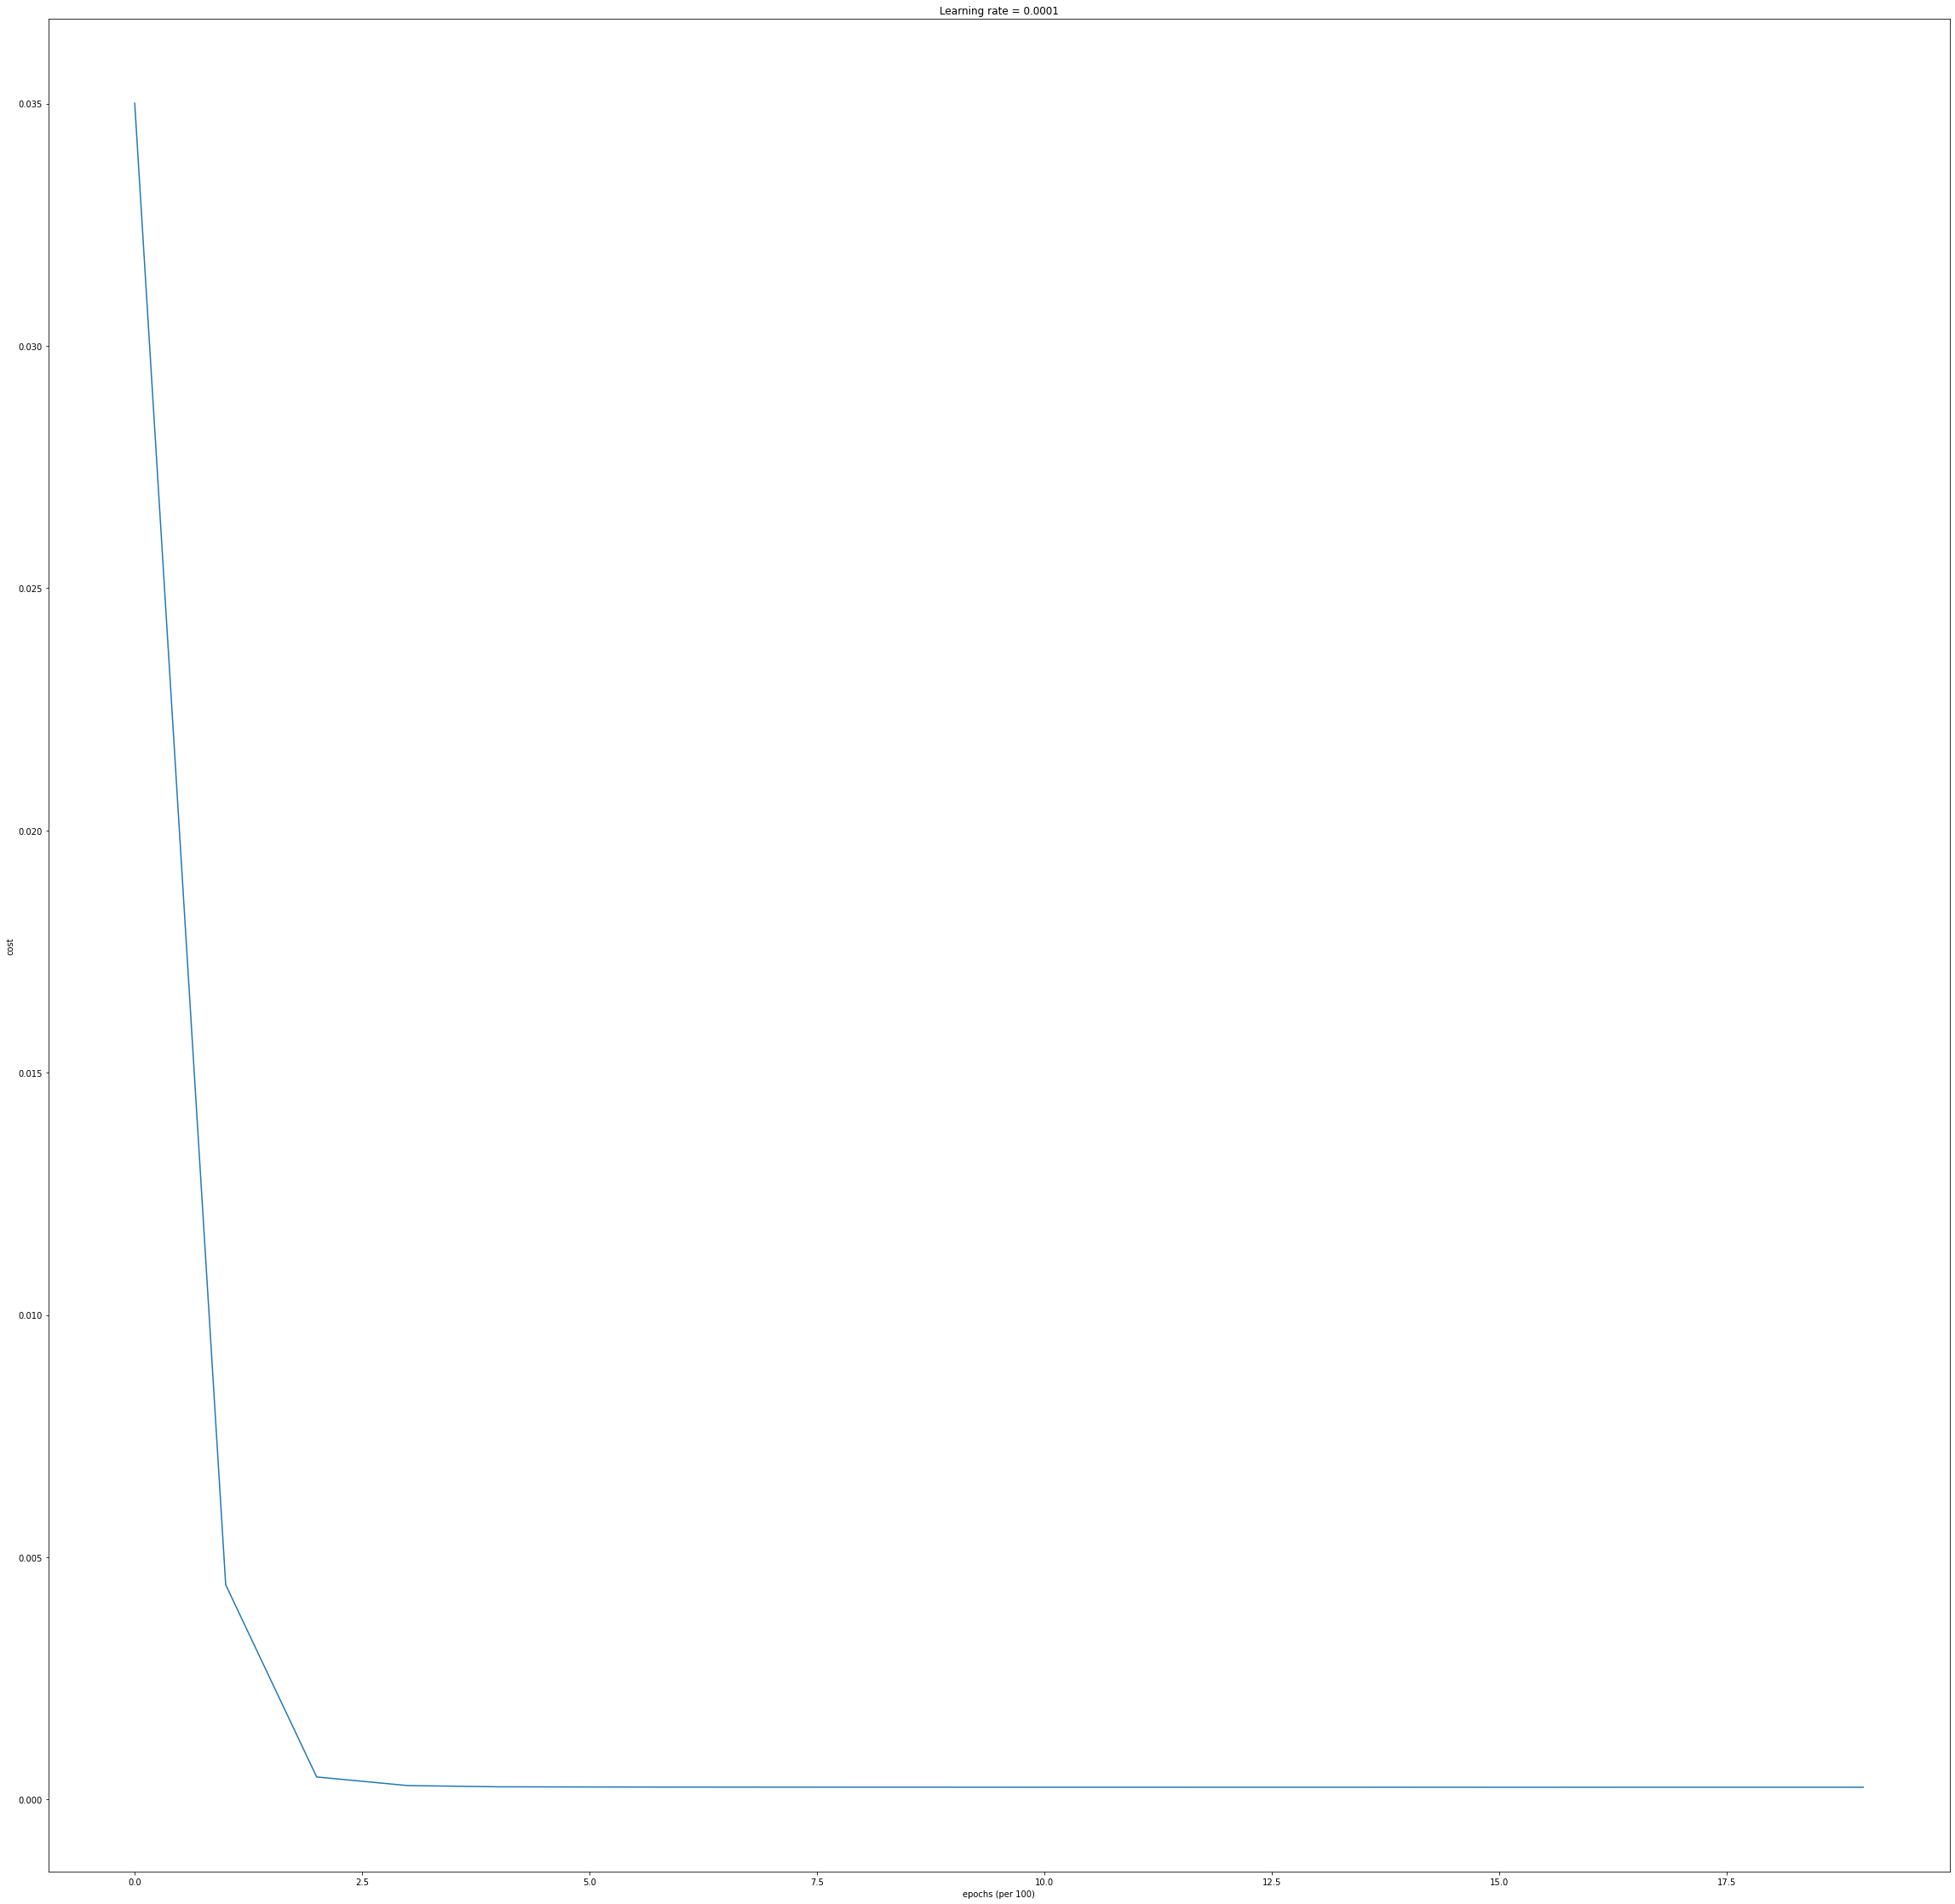

In [80]:
parameters = train_model(mse_X_train, mse_Y_train, layers_dims_mse, num_epochs = 2000, print_cost = True, loss="mse", learning_rate = 0.0001, optimizer="Adam")

In [81]:
pred_train = predict(mse_X_train, mse_Y_train, parameters, loss="mse")

p, caches = L_model_forward(mse_X_train, parameters)
print((p*100-mse_Y_train*100)[:,0:50])

Accuracy: 0.0019447582033858507
[[ 0.69350484 -0.35769196 -1.09050164 -0.06098094  0.16436288 -0.46694175
  -1.2238193   1.0162213  -1.08533223 -0.2169347   0.68270454  0.08391738
  -0.51328275  1.46406802  5.50199508  1.48501706 -0.99702099 -0.8542401
  -1.00032839 -1.35829991 -1.03677797 -0.39284975  1.43239645  1.4590282
   1.63854354  3.62749882  1.31184717 -0.54237571 -5.87917705 -1.1744191
   1.42846766  0.04381845  0.1764205  -1.06776599  1.54353642 -0.11682803
   1.40657953 -2.60100873 -0.32807444 -0.9328194  -0.96199986  0.37852586
   2.04397518  0.67418095 -0.5500225   0.24698201 -0.00966599 -1.02173017
  -1.20420031 -0.88178171]]


In [82]:
pred_test = predict(mse_X_test, mse_Y_test, parameters, loss="mse")

p, caches = L_model_forward(mse_X_test, parameters)

print((mse_Y_test*100)[:,0:10])
print((p*100)[:,0:10])
print((p*100-mse_Y_test*100)[:,0:50])

Accuracy: 0.017381085397431245
[[89. 50. 55. 28. 54. 60. 50. 46. 25. 10.]]
[[85.52033295 50.00540691 55.71574011 27.13528824 54.22693291 61.10723368
  50.18628085 45.20372671 24.48843529 14.09511587]]
[[-3.47966705  0.00540691  0.71574011 -0.86471176  0.22693291  1.10723368
   0.18628085 -0.79627329 -0.51156471  4.09511587  2.37442505  0.46585302
  -0.07879054 -1.10247105  1.17472984 -1.1340639  -0.24054585  3.23084787
  -0.54237571  3.26201112 -1.34133794 -1.00040228  1.4770824   0.87730807
   0.40105022  0.55963927  0.6011621  -0.11682803  0.86301915 -1.33342471
  -1.05395303  0.0735448  -1.39349349 -1.51871696  0.06383654  0.869544
  -1.33030505 -1.31524284 -0.47810263 -3.01633882  0.38356833  2.84642017
   0.81814734  0.98281282  3.25421541  1.42200505  0.63879157 -1.24845219
   2.10373063  0.80614728]]
